<a href="https://colab.research.google.com/github/codelspak/Struggles/blob/main/WK30_Mini_project_DL_CNN_Facial_keypoints_detection_%EC%A0%9C%EC%B6%9C%EC%9A%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 라이브러리, 데이터 불러오기
[Kaggle 노트북 원본 링크](https://www.kaggle.com/code/balraj98/data-augmentation-for-facial-keypoint-detection)

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from math import sin, cos, pi
import cv2
from tqdm.notebook import tqdm

from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model, load_model
from keras.layers import Activation, BatchNormalization
from keras.layers import Flatten, Dense, Dropout
from keras.layers import Convolution2D, MaxPooling2D, Conv2D, MaxPool2D, ZeroPadding2D
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
# from keras.optimizers import Adam

In [ ]:
print("\n현재 작업중인 폴더(working directory):")
!pwd
print("\n작업 폴더에 있는 파일 리스트:")
!ls


현재 작업중인 폴더(working directory):
/home/work/WK30_DL_CNN_Facial keypoints detection

작업 폴더에 있는 파일 리스트:
Face_keypoints__expressions_jh.ipynb
IdLookupTable.csv
SampleSubmission.csv
WK30_Mini_project_DL_CNN_Facial_keypoints_detection.ipynb
WK30_Mini_project_DL_CNN_Facial_keypoints_detection_제출용.ipynb
face-detection_sm.ipynb
facial-keypoints-detection.zip
test.csv
test.zip
training.csv
training.zip


In [ ]:
# !unzip facial-keypoints-detection.zip

In [ ]:
# !unzip test.zip
# !unzip training.zip


In [ ]:
train_data = pd.read_csv('training.csv')
test_data = pd.read_csv('test.csv')
idlookup_data = pd.read_csv('IdLookupTable.csv')

### Augmentation & Hyperparameter Settings

In [ ]:
horizontal_flip = False
rotation_augmentation = False
brightness_augmentation = False
shift_augmentation = False
random_noise_augmentation = False

# 결측치 처리에 대해 다양한 방법이 존재하지만, 여기선 pandas 'ffill' method를 이용해서 앞의 값을 이용해 채워주기로 함
include_unclean_data = True    
# 데이터 증강 시, 코드 정상 작동여부 확인하기 위해 시각화할 샘플 지정
sample_image_index = 20   
# 이미지 회전 시, 시계/반시계 방향으로 해당 각도만큼 돌려줄 것임 (unit: degree)
rotation_angles = [12] 
# 이미지 이동 시, 상하좌우 방향으로 해당 픽셀 만큼 옮겨 줄 것임
pixel_shifts = [12] 

# 모델 학습 파라미터
NUM_EPOCHS = 80
BATCH_SIZE = 64

# Data Exploratory Analysis

In [ ]:
train_data.head().T

,0,1,2,3,4
left_eye_center_x,66.033564,64.332936,65.057053,65.225739,66.725301
left_eye_center_y,39.002274,34.970077,34.909642,37.261774,39.621261
right_eye_center_x,30.227008,29.949277,30.903789,32.023096,32.24481
right_eye_center_y,36.421678,33.448715,34.909642,37.261774,38.042032
left_eye_inner_corner_x,59.582075,58.85617,59.412,60.003339,58.56589
left_eye_inner_corner_y,39.647423,35.274349,36.320968,39.127179,39.621261
left_eye_outer_corner_x,73.130346,70.722723,70.984421,72.314713,72.515926
left_eye_outer_corner_y,39.969997,36.187166,36.320968,38.380967,39.884466
right_eye_inner_corner_x,36.356571,36.034723,37.678105,37.618643,36.98238
right_eye_inner_corner_y,37.389402,34.361532,36.320968,38.754115,39.094852


In [ ]:
test_data.head()

,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...


In [ ]:
idlookup_data.head().T

,0,1,2,3,4
RowId,1,2,3,4,5
ImageId,1,1,1,1,1
FeatureName,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x
Location,NaN,NaN,NaN,NaN,NaN


In [ ]:
# 결측치
print("Train data 샘플 수(length): {}".format(len(train_data)))
print("결측치(pixel) 포함 Train data 수: {}".format(len(train_data) - int(train_data.Image.
                                                                    apply(lambda x: len(x.split())).value_counts().values)))

Train data 샘플 수(length): 7049
결측치(pixel) 포함 Train data 수: 0


In [ ]:
# train data 결측치 확인
train_data.isnull().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

In [ ]:
# train data 결측치 - 비율 확인
train_data.isnull().mean() * 100

left_eye_center_x             0.141864
left_eye_center_y             0.141864
right_eye_center_x            0.184423
right_eye_center_y            0.184423
left_eye_inner_corner_x      67.782664
left_eye_inner_corner_y      67.782664
left_eye_outer_corner_x      67.839410
left_eye_outer_corner_y      67.839410
right_eye_inner_corner_x     67.825223
right_eye_inner_corner_y     67.825223
right_eye_outer_corner_x     67.825223
right_eye_outer_corner_y     67.825223
left_eyebrow_inner_end_x     67.796851
left_eyebrow_inner_end_y     67.796851
left_eyebrow_outer_end_x     68.435239
left_eyebrow_outer_end_y     68.435239
right_eyebrow_inner_end_x    67.796851
right_eyebrow_inner_end_y    67.796851
right_eyebrow_outer_end_x    68.279189
right_eyebrow_outer_end_y    68.279189
nose_tip_x                    0.000000
nose_tip_y                    0.000000
mouth_left_corner_x          67.811037
mouth_left_corner_y          67.811037
mouth_right_corner_x         67.796851
mouth_right_corner_y     

### 결측치 제거한 Clean data 생성

In [ ]:
%%time

# 결측치 제거
clean_train_data = train_data.dropna()
print("clean_train_data shape: {}".format(np.shape(clean_train_data)))

# 'ffill' stands for 'forward fill' > propagate last valid observation forward
# 참고: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html
unclean_train_data = train_data.fillna(method = 'ffill')
print("unclean_train_data shape: {}\n".format(np.shape(unclean_train_data)))

clean_train_data shape: (2140, 31)
unclean_train_data shape: (7049, 31)

CPU times: user 7.51 ms, sys: 591 µs, total: 8.1 ms
Wall time: 6.87 ms


In [ ]:
# 이미지 데이터 정보 확인
clean_train_data.loc[0, 'Image']

'238 236 237 238 240 240 239 241 241 243 240 239 231 212 190 173 148 122 104 92 79 73 74 73 73 74 81 74 60 64 75 86 93 102 100 105 109 114 121 127 132 134 137 137 140 139 138 137 137 140 141 143 144 147 148 149 147 147 148 145 147 144 146 147 147 143 134 130 130 128 116 104 98 90 82 78 85 88 86 80 77 87 108 111 115 128 133 188 242 252 250 248 251 250 250 250 235 238 236 238 238 237 238 242 241 239 237 233 215 195 187 156 119 103 93 78 68 73 75 75 72 75 70 61 66 77 91 96 106 108 113 120 125 131 134 138 135 138 139 145 144 144 142 140 141 141 148 147 150 149 152 151 149 150 147 148 144 148 144 146 146 143 139 128 132 135 128 112 104 97 87 78 79 83 85 83 75 75 89 109 111 117 117 130 194 243 251 249 250 249 250 251 237 236 237 238 237 238 241 238 238 238 241 221 195 187 163 124 106 95 81 68 70 73 73 72 73 69 65 74 82 94 103 110 111 119 127 135 140 139 144 144 145 143 143 143 146 144 144 147 146 148 147 150 146 147 150 150 149 147 147 144 147 144 149 146 144 144 144 140 131 133 133 125 110 

In [ ]:
len(clean_train_data.loc[0, 'Image'])

33593

아 부끄럽지만 내 패착의 요인을 찾았다.<br>
그, 위에 length가 image array의 요소 수가 아니라, 띄어쓰기를 포함한 전체 글자 수였음....<br>
그래서 아래에서 str.split(' ') 결과값을 반환한 리스트의 length와 값이 다른 것임... :)

In [ ]:
type(clean_train_data.loc[0, 'Image'].split(' '))

list

In [ ]:
len(clean_train_data.loc[0, 'Image'].split(' '))

9216

In [ ]:
len(clean_train_data.loc[1000, 'Image'].split(' '))

9216

In [ ]:
len(clean_train_data.loc[256, 'Image'].split(' '))

9216

In [ ]:
np.sqrt(9216)

96.0

위 과정을 통해 모든 Image 데이터를 이루는 array number 수는 총 9216개 임을 알 수 있음.<br>
따라서 눈에 보이는 형태로 이미지를 시각화해주기 위해 96*96 정사각형 형태로 형태 변경해줌.

In [ ]:
%%time

def load_images(image_data):
    images = []
    
    for idx, sample in image_data.iterrows():
        # 데이터가 띄어쓰기 기준으로 주어져 있음 - 픽셀 정보 분리해서 2D Array 형태로 바꿔줌
        image = np.array(sample['Image'].split(' '), dtype=int)
        # np.sqrt(9216) = 96
        image = np.reshape(image, (96,96,1))
        images.append(image)
    # 픽셀 값(0~255) 기준 정규화 > 0~1 값 사이로 바꿔줌
    images = np.array(images)/255.0
    
    return images

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs


In [ ]:
%%time

def load_keypoints(keypoint_data):
    keypoint_data = keypoint_data.drop('Image',axis = 1)
    keypoint_features = []
    
    for idx, sample_keypoints in keypoint_data.iterrows():
        keypoint_features.append(sample_keypoints)
        
    keypoint_features = np.array(keypoint_features, dtype = 'float')
    
    return keypoint_features


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs


### 시각화에 사용할 데이터 생성(clean_train_images, clean_train_keypoints)

In [ ]:
clean_train_images = load_images(clean_train_data)
print(f"Type of clean_train_images: {type(clean_train_images)}")
print("Shape of clean_train_images: {}".format(np.shape(clean_train_images)))
clean_train_keypoints = load_keypoints(clean_train_data)
print(f"Type of clean_train_keypoints: {type(clean_train_keypoints)}")
print("Shape of clean_train_keypoints: {}".format(np.shape(clean_train_keypoints)))
test_images = load_images(test_data)
print("Shape of test_images: {}".format(np.shape(test_images)))

Type of clean_train_images: <class 'numpy.ndarray'>
Shape of clean_train_images: (2140, 96, 96, 1)
Type of clean_train_keypoints: <class 'numpy.ndarray'>
Shape of clean_train_keypoints: (2140, 30)
Shape of test_images: (1783, 96, 96, 1)


### 이미지 위에 keypoints 시각화해 줄 함수 정의

In [ ]:
def plot_sample(image, keypoint, axis, title):
    image = image.reshape(96,96)
    axis.imshow(image, cmap='gray')
    axis.scatter(keypoint[0::2], keypoint[1::2], marker='x', s=20)
    plt.title(title)

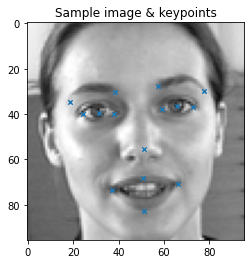

In [ ]:
# 결측치 제거한 clean data로 학습 데이터 만들어줌(증강시켜줄거임)
train_images = clean_train_images
train_keypoints = clean_train_keypoints

# nrows, ncols 지정 안 하고, axis 변수를 선언하여, 앞에서 설정한 20개 데이터 활용해줄 것임
fig, axis = plt.subplots()
plot_sample(clean_train_images[sample_image_index], 
            clean_train_keypoints[sample_image_index], 
            axis, "Sample image & keypoints")


In [ ]:
# clean_train_data = train_data.dropna()
# unclean_train_data = train_data.fillna(method = 'ffill')
# 앞서 augmentation & parameter seting에서 선언한 변수(ex. include_unclean_data)가 True면, 아래 코드를 실행
if include_unclean_data:
    unclean_train_images = load_images(unclean_train_data)
    print("Shape of unclean_train_images: {}".format(np.shape(unclean_train_images)))
    unclean_train_keypoints = load_keypoints(unclean_train_data)
    print("Shape of unclean_train_keypoints: {}\n".format(np.shape(unclean_train_keypoints)))
    # 배열 간 결합 : np.concatenate
    # 병합한, 전체 이미지 배열 만들어줌
    train_images = np.concatenate((train_images, unclean_train_images))
    train_keypoints = np.concatenate((train_keypoints, unclean_train_keypoints))

Shape of unclean_train_images: (7049, 96, 96, 1)
Shape of unclean_train_keypoints: (7049, 30)



# 3. Data Augmentation

### 3.1. 좌우반전(horizontal flip)

In [ ]:
def left_right_flip(images, keypoints):
    flipped_keypoints = []
    
    # axis = 2: column-wise
    # The default: axis=None > flip over all of the axes of the input array.
    # If axis is negative: it counts from the last to the first axis.
    flipped_images = np.flip(images, axis=2)   
    
    # enumerate() lets you write Pythonic for loops when you need a count and the value from an iterable. 
    # it returns a tuple with the counter and value, so you don't have to increment the counter yourself.
    for idx, sample_keypoints in enumerate(keypoints):
        # 좌우반전 : y좌표는 그대로 유지, x좌표면 반대로 뒤집어줌
        # x좌표 index = 2n 패턴 이용해, 좌표 추출해 변경해줌
        flipped_keypoints.append([96.-coor if idx%2==0 else coor for idx, coor in enumerate(sample_keypoints)])    
        
    return flipped_images, flipped_keypoints


In [ ]:
if horizontal_flip:
    flipped_train_images, flipped_train_keypoints = left_right_flip(clean_train_images, clean_train_keypoints)
    print("Shape of flipped_train_images: {}".format(np.shape(flipped_train_images)))
    print("Shape of flipped_train_keypoints: {}".format(np.shape(flipped_train_keypoints)))
    train_images = np.concatenate((train_images, flipped_train_images)) 
    fig, axis = plt.subplots()
    plot_sample(flipped_train_images[sample_image_index], flipped_train_keypoints[sample_image_index], 
                axis, "Horizontally Flipped") 

### 3.2. 회전(rotation)

In [ ]:
def rotate_augmentation(images, keypoints):
    rotated_images = []
    rotated_keypoints = []
    print("Augmenting for angles (in degrees): ")
    
    for angle in rotation_angles:
        # 지정한 각도에 대해, 시계/반시계 방향으로 회전시켜줌 (따라서 리스트 형태로 만들어줌)
        for angle in [angle,-angle]:
            print(f'{angle}', end='  ')
            # 행렬 변환
            M = cv2.getRotationMatrix2D((48,48), angle, 1.0)
            # 각도 > 라디안 변환
            angle_rad = -angle*pi/180.     
            
            # train_images
            for image in images:
                rotated_image = cv2.warpAffine(image, M, (96,96), flags=cv2.INTER_CUBIC)
                rotated_images.append(rotated_image)
                
            # train_keypoints
            for keypoint in keypoints:
                # 해당 차원에서 이미지 중심 좌표만큼 빼줌
                rotated_keypoint = keypoint - 48.0
                
                for idx in range(0, len(rotated_keypoint), 2):
                    # https://in.mathworks.com/matlabcentral/answers/93554-how-can-i-rotate-a-set-of-points-in-a-plane-by-a-certain-angle-about-an-arbitrary-point
                    rotated_keypoint[idx] = rotated_keypoint[idx]*cos(angle_rad)-rotated_keypoint[idx+1]*sin(angle_rad)
                    rotated_keypoint[idx+1] = rotated_keypoint[idx]*sin(angle_rad)+rotated_keypoint[idx+1]*cos(angle_rad)
                # 위에서 빼줬던 좌표 값 다시 더해줌
                rotated_keypoint += 48.0
                rotated_keypoints.append(rotated_keypoint)
            
    return np.reshape(rotated_images,(-1,96,96,1)), rotated_keypoints


In [ ]:
if rotation_augmentation:
    rotated_train_images, rotated_train_keypoints = rotate_augmentation(clean_train_images, clean_train_keypoints)
    print("\nShape of rotated_train_images: {}".format(np.shape(rotated_train_images)))
    print("Shape of rotated_train_keypoints: {}\n".format(np.shape(rotated_train_keypoints)))
    # 학습 데이터에 증강 데이터 추가해줌
    train_images = np.concatenate((train_images, rotated_train_images))
    train_keypoints = np.concatenate((train_keypoints, rotated_train_keypoints))
    # 시각화
    fig, axis = plt.subplots()
    plot_sample(rotated_train_images[sample_image_index], rotated_train_keypoints[sample_image_index], 
                axis, "Rotation Augmentation")

### 밝기 조절(brightness alteration)

In [ ]:
import numpy as np
np.clip?

In [ ]:
def alter_brightness(images, keypoints):
    altered_brightness_images = []
    
    # np.clip(array, 하한값, 상한값) : 하한값 이하는 모두 하한값 / 상한값 이상은 모두 상한값으로 변경
    # Equivalent to but faster than ``np.minimum(a_max, np.maximum(a, a_min))``
    inc_brightness_images = np.clip(images*1.2, 0.0, 1.0)    
    dec_brightness_images = np.clip(images*0.6, 0.0, 1.0)    
    # 리스트 형태로 통으로 넣어주는 append 말고, 요소 하나씩 넣어주는 extend 사용
    altered_brightness_images.extend(inc_brightness_images)
    altered_brightness_images.extend(dec_brightness_images)
    
    return altered_brightness_images, np.concatenate((keypoints, keypoints))


In [ ]:
if brightness_augmentation:
    altered_brightness_train_images, altered_brightness_train_keypoints = alter_brightness(clean_train_images, 
                                                                                           clean_train_keypoints)
    
    print(f"Shape of altered_brightness_train_images: {np.shape(altered_brightness_train_images)}")
    print(f"Shape of altered_brightness_train_keypoints: {np.shape(altered_brightness_train_keypoints)}")
    
    train_images = np.concatenate((train_images, altered_brightness_train_images))
    train_keypoints = np.concatenate((train_keypoints, altered_brightness_train_keypoints))
    
    fig, axis = plt.subplots()
    plot_sample(altered_brightness_train_images[sample_image_index], altered_brightness_train_keypoints[sample_image_index], 
                axis, "Increased Brightness") 
    fig, axis = plt.subplots()
    plot_sample(altered_brightness_train_images[len(altered_brightness_train_images)//2+sample_image_index], 
                altered_brightness_train_keypoints[len(altered_brightness_train_images)//2+sample_image_index], 
                axis, "Decreased Brightness") 

### 3.4. 상하좌우 이동(horizontal & vertical shift)

In [ ]:
def shift_images(images, keypoints):
    shifted_images = []
    shifted_keypoints = []
    
    for shift in pixel_shifts:    
        # 앞에서 설정한 pixel_shift value에 대해, 4가지 케이스로 나누어 증강
        for (shift_x,shift_y) in [(-shift,-shift), (-shift,shift), (shift,-shift), (shift,shift)]:
            # Init signature: np.float32(self, /, *args, **kwargs)
            # Single-precision floating-point number type, compatible with C ``float``.
            M = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
            # returns a zip object, which is an iterator of tuples 
            # where the first item in each passed iterator is paired together
            for image, keypoint in zip(images, keypoints):
                shifted_image = cv2.warpAffine(image, M, (96,96), flags=cv2.INTER_CUBIC)
                shifted_keypoint = np.array([(point+shift_x) if idx%2==0 
                                             else (point+shift_y) for idx, point in enumerate(keypoint)])
                if np.all(shifted_keypoint>0.0) and np.all(shifted_keypoint<96.0):
                    shifted_images.append(shifted_image.reshape(96,96,1))
                    shifted_keypoints.append(shifted_keypoint)
    shifted_keypoints = np.clip(shifted_keypoints,0.0,96.0)
    
    return shifted_images, shifted_keypoints


In [ ]:
if shift_augmentation:
    shifted_train_images, shifted_train_keypoints = shift_images(clean_train_images, clean_train_keypoints)
    
    print(f"Shape of shifted_train_images: {np.shape(shifted_train_images)}")
    print(f"Shape of shifted_train_keypoints: {np.shape(shifted_train_keypoints)}")
    
    train_images = np.concatenate((train_images, shifted_train_images))
    train_keypoints = np.concatenate((train_keypoints, shifted_train_keypoints))
    
    fig, axis = plt.subplots()
    plot_sample(shifted_train_images[sample_image_index], shifted_train_keypoints[sample_image_index], 
                axis, "Shift Augmentation")

### 3.5. random noise 생성

In [ ]:
def add_noise(images):
    noisy_images = []
    
    for image in images:
        # cv2.add? brief Calculates the per-element sum of two arrays or an array and a scalar.
        noisy_image = cv2.add(image, 0.008*np.random.randn(96,96,1))    
        noisy_images.append(noisy_image.reshape(96,96,1))
        
    return noisy_images


In [ ]:
if random_noise_augmentation:
    noisy_train_images = add_noise(clean_train_images)
    
    print(f"Shape of noisy_train_images: {np.shape(noisy_train_images)}")
    
    train_images = np.concatenate((train_images, noisy_train_images))
    train_keypoints = np.concatenate((train_keypoints, clean_train_keypoints))
    
    fig, axis = plt.subplots()
    plot_sample(noisy_train_images[sample_image_index], clean_train_keypoints[sample_image_index], 
                axis, "Random Noise Augmentation")

# 4. Modeling and Training

### 4.1.train data 시각화(images and keypoints)

Shape of final train_images: (9189, 96, 96, 1)
Shape of final train_keypoints: (9189, 30)

 Clean Train Data(결측치 제거 후 증강): 


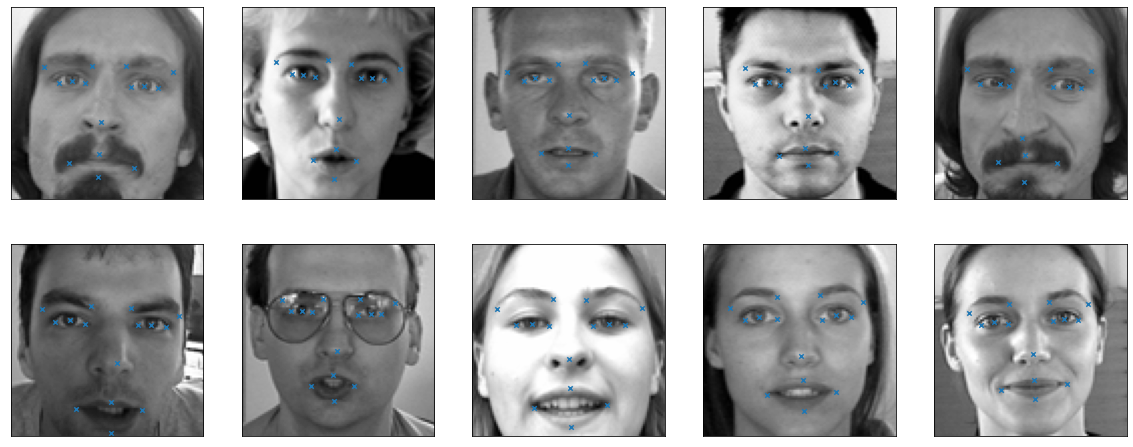

In [ ]:
print("Shape of final train_images: {}".format(np.shape(train_images)))
print("Shape of final train_keypoints: {}".format(np.shape(train_keypoints)))

print("\n Clean Train Data(결측치 제거 후 증강): ")
fig = plt.figure(figsize=(20,8))

for i in range(10):
    axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    plot_sample(clean_train_images[i], clean_train_keypoints[i], axis, "")
plt.show()


In [ ]:
# 데이터 증강 여부에 따른 시각화 함수 정의
# augmentation 종류에 따른, 최종 train image/keypoints 이름 패턴
# aug_pair_images = {'include_unclean_data': 'unclean_train_images',
#                     'horizontal_flip': 'flipped_train_images',
#                     'rotation_augmentation': 'rotated_train_images',
#                     'brightness_augmentation': 'altered_brightness_train_images',
#                     'shift_augmentation': 'shifted_train_images',
#                     'random_noise_augmentation': 'noisy_train_images',
#                    }
# aug_pair_keypoints = {'include_unclean_data': 'unclean_train_keypoints',
#                     'horizontal_flip': 'flipped_train_keypoints',
#                     'rotation_augmentation': 'rotated_train_keypoints',
#                     'brightness_augmentation': 'altered_brightness_train_keypoints',
#                     'shift_augmentation': 'shifted_train_keypoints',
#                     'random_noise_augmentation': 'clean_train_keypoints',
#                    }


Unclean Train Data: 


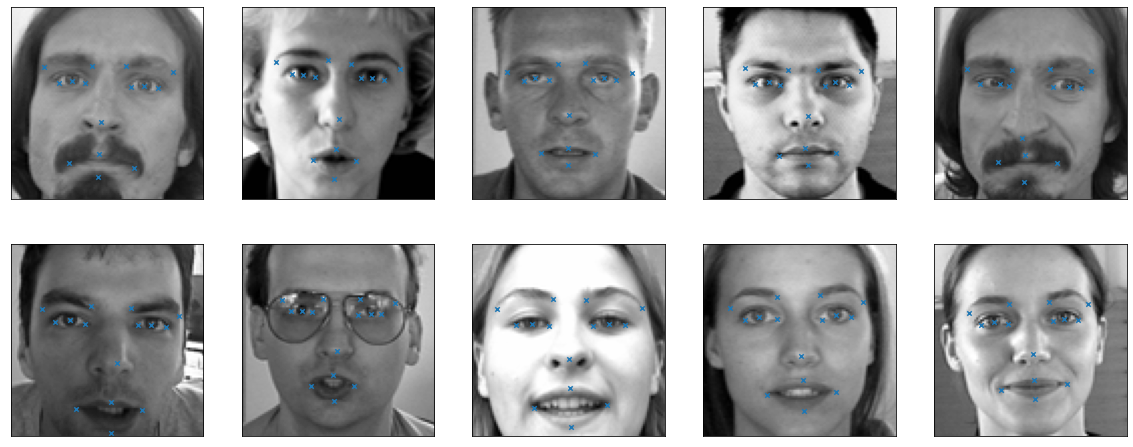

In [ ]:
# 데이터 증강 여부에 따른 시각화 코드
if include_unclean_data:
    print("Unclean Train Data: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(unclean_train_images[i], unclean_train_keypoints[i], axis, "")
    plt.show()

if horizontal_flip:
    print("Horizontal Flip Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(flipped_train_images[i], flipped_train_keypoints[i], axis, "")
    plt.show()

if rotation_augmentation:
    print("Rotation Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(rotated_train_images[i], rotated_train_keypoints[i], axis, "")
    plt.show()
    
if brightness_augmentation:
    print("Brightness Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(altered_brightness_train_images[i], altered_brightness_train_keypoints[i], axis, "")
    plt.show()

if shift_augmentation:
    print("Shift Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(shifted_train_images[i], shifted_train_keypoints[i], axis, "")
    plt.show()
    
if random_noise_augmentation:
    print("Random Noise Augmentation: ")
    fig = plt.figure(figsize=(20,8))
    for i in range(10):
        axis = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
        plot_sample(noisy_train_images[i], clean_train_keypoints[i], axis, "")
    plt.show()

### 4.2. modeling

In [ ]:
model = Sequential()

# Input dimensions: (None, 96, 96, 1)
model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(96,96,1)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
# Input dimensions: (None, 96, 96, 32)
model.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# # Input dimensions: (None, 48, 48, 32)
# model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
# model.add(LeakyReLU(alpha = 0.1))
# model.add(BatchNormalization())
# # Input dimensions: (None, 48, 48, 64)
# model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
# model.add(LeakyReLU(alpha = 0.1))
# model.add(BatchNormalization())
# model.add(MaxPool2D(pool_size=(2, 2)))

# Input dimensions: (None, 24, 24, 64)
model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
# Input dimensions: (None, 24, 24, 96)
model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

# # Input dimensions: (None, 12, 12, 96)
# model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
# model.add(LeakyReLU(alpha = 0.1))
# model.add(BatchNormalization())
# # Input dimensions: (None, 12, 12, 128)
# model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
# model.add(LeakyReLU(alpha = 0.1))
# model.add(BatchNormalization())
# model.add(MaxPool2D(pool_size=(2, 2)))

# # Input dimensions: (None, 6, 6, 128)
# model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
# model.add(LeakyReLU(alpha = 0.1))
# model.add(BatchNormalization())
# # Input dimensions: (None, 6, 6, 256)
# model.add(Convolution2D(256, (3,3),padding='same',use_bias=False))
# model.add(LeakyReLU(alpha = 0.1))
# model.add(BatchNormalization())
# model.add(MaxPool2D(pool_size=(2, 2)))

# Input dimensions: (None, 3, 3, 256)
model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
# Input dimensions: (None, 3, 3, 512)
model.add(Convolution2D(512, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

# Input dimensions: (None, 3, 3, 512)
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(30))
model.summary()

2022-07-17 11:44:50.743979: I tensorflow/core/platform/cpu_feature_guard.cc:152] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-17 11:44:51.383833: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2445 MB memory:  -> device: 0, name: CUDA GPU, pci bus id: 0000:e5:00.0, compute capability: 7.0


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 32)        288       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 96, 96, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 96, 96, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 32)        9216      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 96, 96, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 96, 96, 32)       128       
 hNormalization)                                        

### 4.3. train, fit

In [ ]:
%%time

# Load a pre-trained model (if present)
if os.path.exists('../input/data-augmentation-for-facial-keypoint-detection/best_model.hdf5'):
    model = load_model('../input/data-augmentation-for-facial-keypoint-detection/best_model.hdf5')

# callback
checkpointer = ModelCheckpoint(filepath = 'best_model.hdf5', monitor='val_mae', 
                               verbose=1, save_best_only=True, mode='min')

# compile
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'acc'])

# train
history = model.fit(train_images, train_keypoints, 
                    epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, 
                    validation_split=0.05, 
                    callbacks=[checkpointer])

In [ ]:
# summarize history for mean_absolute_error
try:
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Mean Absolute Error vs Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Accuracy vs Epoch')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss vs Epoch')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
except:
    print("One of the metrics used for plotting graphs is missing! See 'model.compile()'s `metrics` argument.")

In [ ]:
%%time

# Modify ModelCheckpoint callback to save model with best train mae to disk (instead of best validation mae)
checkpointer = ModelCheckpoint(filepath = 'best_model.hdf5', monitor='mae', verbose=1, save_best_only=True, mode='min')
model.fit(train_images, train_keypoints, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=[checkpointer])

# 5. Predict and submit

In [ ]:
# predict
%%time
 
model = load_model('best_model.hdf5')
test_preds = model.predict(test_images)

In [ ]:
# 예측 결과 시각화
fig = plt.figure(figsize=(20,16))
for i in range(20):
    axis = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
    plot_sample(test_images[i], test_preds[i], axis, "")
plt.show()

In [ ]:
# 제출 파일
feature_names = list(idlookup_data['FeatureName'])
image_ids = list(idlookup_data['ImageId']-1)
row_ids = list(idlookup_data['RowId'])

feature_list = []
for feature in feature_names:
    feature_list.append(feature_names.index(feature))
    
predictions = []
for x,y in zip(image_ids, feature_list):
    predictions.append(test_preds[x][y])
    
row_ids = pd.Series(row_ids, name = 'RowId')
locations = pd.Series(predictions, name = 'Location')
locations = locations.clip(0.0,96.0)
submission_result = pd.concat([row_ids,locations],axis = 1)
submission_result.to_csv('submission.csv',index = False)